In [1]:
import numpy as np
import pandas as pd
import os
import pickle


from importlib.metadata import version 
version('statsmodels')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from datetime import datetime

from load_data import *
from features import *
from cv import *
from post_process import *

# os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'

FREQ = [5,10,15]

import warnings
warnings.filterwarnings('ignore')

# from importlib.metadata import version 
# version('statsmodels')




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## I. Load historical data + resampling

In [2]:
reload = False

if reload is True:
    crypto_data = LoadTransformCryptoData()

    crypto_raw = crypto_data.raw_data.copy()
    crypto_resampled = crypto_data.resampled_data.copy()

    with open('output/crypto_raw.pickle', 'wb') as handle:
        pickle.dump(crypto_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('output/crypto_resampled.pickle', 'wb') as handle:
        pickle.dump(crypto_resampled, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('output/crypto_raw.pickle', 'rb') as handle:
        crypto_raw = pickle.load(handle)
    
    with open('output/crypto_resampled.pickle', 'rb') as handle:
        crypto_resampled = pickle.load(handle)

CRYPTOS = list(crypto_raw.keys())
print(len(CRYPTOS))
freq = 15
crypto_resampled[freq]['ADA'].head()

56


,open,high,low,close,volume,close%,volume%
timestamp,,,,,,,
2023-06-09 12:30:00,0.3183,0.3240,0.3183,0.3211,12736328.5,0.008797,NaN
2023-06-09 12:45:00,0.3217,0.3223,0.3201,0.3216,2910014.5,-0.000311,-0.771519
2023-06-09 13:00:00,0.3213,0.3218,0.3195,0.3213,3060284.6,0.000000,0.051639
2023-06-09 13:15:00,0.3211,0.3217,0.3192,0.3203,2497423.3,-0.002491,-0.183924
2023-06-09 13:30:00,0.3205,0.3218,0.3197,0.3201,1327505.6,-0.001248,-0.468450


### Cryptos correlations

In [3]:
for param in ['close%','close']:
    close_all = None
    for crypto in CRYPTOS:
        _df = crypto_resampled[freq][crypto][[param]].rename(columns = {param:crypto})
        close_all = _df if close_all is None else close_all.merge(_df,left_index=True,right_index=True)
        
    close_all[['BTC','ETH','ADA'] + [i for i in close_all.columns if i not in ['BTC','ETH','ADA']]].corr().to_excel(f'output/{param}_corr_cryptos.xlsx')

## II. Feature engineering & selection

In [4]:
selected_freq = 15 #select freq
working_dict = crypto_resampled[selected_freq].copy()

features = FeatureEngineering(_dict=working_dict)
features.run()

ENDOG = 'close%'

### a. correlations

In [5]:
@interact
def show_corr(crypto = ['BTC','ETH','ADA','DASH']):
    #split columns
    df = features.crypto_modelling[crypto].copy()
    
    BINARY_COLUMNS = list(df.columns[df.isin([0,1]).all()])
    EXOG_NUMERICAL= [i for i in df.columns if i not in BINARY_COLUMNS and i!= ENDOG]
    print(len(EXOG_NUMERICAL+BINARY_COLUMNS))
    
    order_feature_corr = list(abs(df[[ENDOG]+EXOG_NUMERICAL].drop(columns = ['month','day','hour']).corr()).sort_values('close%',ascending=False).index)
    corr = df[order_feature_corr].corr()
    corr.to_excel(f'output/feature_corr_{crypto}.xlsx')

    return corr.head()
    

interactive(children=(Dropdown(description='crypto', options=('BTC', 'ETH', 'ADA', 'DASH'), value='BTC'), Outp…

### b. VIF

In [6]:
start_vif = False
if start_vif is True:
    crypto = 'BTC'
    df = features.crypto_modelling[crypto].copy()
    
    BINARY_COLUMNS = list(df.columns[df.isin([0,1]).all()])
    EXOG_NUMERICAL= [i for i in df.columns if i not in BINARY_COLUMNS and i!= ENDOG]
    
    data = df[BINARY_COLUMNS+EXOG_NUMERICAL]
    vif_iterations = []
    
    initial_set_features = BINARY_COLUMNS+EXOG_NUMERICAL
    X = df[initial_set_features]
    for iteration_count in range(1,len(initial_set_features)+1):
        drop_feature, df_vif = calculate_vif(X, threshold = 10)
        print(f'Iteration: {iteration_count}',',drop: ',drop_feature)
        vif_iterations.append(df_vif)
        if drop_feature is None:
            break
        X = X.drop(columns = [drop_feature])

    with open('output/vif_iterations.pickle', 'wb') as handle:
        pickle.dump(vif_iterations, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('output/vif_iterations.pickle', 'rb') as handle:
        vif_iterations = pickle.load(handle)

SELECTED_FEATURES_VIF = list(vif_iterations[-1].index)

print(f'Total # vif iterations: {len(vif_iterations)}')    
print(f'Final selected columns: {SELECTED_FEATURES_VIF}')    



Total # vif iterations: 23
Final selected columns: ['rol_std_close_20', 'month', 'HLC', 'rol_std_close_3', 'rol_mean_volume_20', 'rol_mean_volume_10', 'day', 'hour', 'rol_mean_volume_5', 'year', 'signal_line', 'rol_mean_volume_3', 'day_of_week_Sunday', 'day_of_week_Saturday', 'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Wednesday', 'day_of_week_Tuesday', 'volume%', 'ema_mean_3', 'close%_1lags', 'close%_3lags', 'close%_2lags', 'close%_5lags', 'close%_6lags', 'close%_7lags', 'close%_8lags', 'close%_9lags', 'close%_19lags', 'close%_10lags', 'close%_17lags', 'close%_16lags', 'close%_11lags', 'close%_15lags', 'close%_12lags', 'close%_14lags', 'close%_13lags']


In [7]:
@interact
def show_corr(crypto = ['BTC','ETH','ADA','DASH']):
    #split columns
    ENDOG = 'close%'
    df = features.crypto_modelling[crypto][[ENDOG]+SELECTED_FEATURES_VIF]
    
    BINARY_COLUMNS = list(df.columns[df.isin([0,1]).all()])
    EXOG_NUMERICAL= [i for i in df.columns if i not in BINARY_COLUMNS and i!= ENDOG]
    print(len(EXOG_NUMERICAL+BINARY_COLUMNS))
    
    order_feature_corr = list(abs(df[[ENDOG]+EXOG_NUMERICAL].drop(columns = ['month','day','hour']).corr()).sort_values('close%',ascending=False).index)
    corr = df[order_feature_corr].corr()
    corr.to_excel(f'output/after_vif_feature_corr_{crypto}.xlsx')

    return corr.head()

interactive(children=(Dropdown(description='crypto', options=('BTC', 'ETH', 'ADA', 'DASH'), value='BTC'), Outp…

### b. PCA

In [8]:
crypto = 'BTC'
variance_threshold=0.8
df=features.crypto_modelling[crypto][SELECTED_FEATURES_VIF]
cumulative_variance, n_components, components_df = pca_analysis(df=df,endog='close%',variance_threshold=variance_threshold)

weight_threshold = 0.2
SELECTED_FEATURES_PCA = []
for component in ['PC1','PC2','PC3']:
    selected_features = [k for k,v in components_df[[component]].sort_values(component,ascending=False).to_dict()[component].items() if v>=weight_threshold]
    SELECTED_FEATURES_PCA.append(selected_features) 

import itertools

SELECTED_FEATURES_PCA = list(set(list(itertools.chain(*SELECTED_FEATURES_PCA))))
print(len(SELECTED_FEATURES_PCA))

14


In [9]:
@interact

def pca(crypto=['BTC','ETH','ADA','DASH'],variance_threshold=[0.8,0.9]):
    
    df=features.crypto_modelling[crypto][SELECTED_FEATURES_VIF]
    cumulative_variance, n_components, components_df = pca_analysis(df=df,endog='close%',variance_threshold=variance_threshold)
    
    fig = px.line(cumulative_variance).update_layout(template='presentation'
                                                     ,title = 'Explained Variance'
                                                     ,yaxis = {"title": '','tickformat':".0%"}
                                                     ,xaxis = {"title": '#PC'}
                                                     ,font_size=12
                                                     ,height=500
                                                     ,width=500
                                                     ,showlegend=False) #day_of_week, weekday

    return fig.show(), components_df[['PC1','PC2','PC3']].head()


interactive(children=(Dropdown(description='crypto', options=('BTC', 'ETH', 'ADA', 'DASH'), value='BTC'), Drop…

In [11]:
@interact
def plot_box(crypto = ['BTC','ETH','ADA','DASH'],column=['weekday','month','day','year']):
    df = features.crypto_modelling[crypto].copy()
    fig = px.box(df, y='close%', x=column).update_layout(template='presentation',height=800,width=1000) #day_of_week, weekday
    
    return fig.show()

interactive(children=(Dropdown(description='crypto', options=('BTC', 'ETH', 'ADA', 'DASH'), value='BTC'), Drop…

## III. Cross validation

In [12]:
#sets creation per crypto
train_size = 1000
test_size = 1

splits = {}
for crypto in CRYPTOS:         
    #select crypto data modelling
    df=features.crypto_modelling[crypto].copy()
    
    #split based on train/dest dataset
    cst = CustomTimeSeriesSplit(X=df.index, train_size=train_size, test_size=test_size) 
    cst.run()

    splits[crypto] = {}
    for i, (train_index, test_index) in enumerate(cst.splits):
        splits[crypto][i] = [train_index,test_index]


#### visualize resampling on cv set

In [13]:
@interact
def resample_result(crypto = ['BTC','ETH'],col = ['close','close%']):
    cv_set = splits[crypto][len(splits[crypto])-1][0] #train
    start_period = np.min(cv_set)
    end_period = np.max(cv_set)
    print(start_period,end_period)
    
    df_filtered_1 = crypto_resampled[1][crypto][[col]].loc[start_period:end_period]
    df_filtered_15 = crypto_resampled[15][crypto][[col]].loc[start_period:end_period]
 
    fig = px.line(df_filtered_1,template = 'presentation')
    fig.update_layout(template='presentation',title=f'{crypto} {col}',height=500,width=1500,yaxis={'title':''},xaxis={'title':''},font_size=12,showlegend=False)
    fig_resampled_15 = px.line(df_filtered_15,template = 'presentation')
    fig_resampled_15.update_layout(template='presentation',title=f'{crypto} {col}',height=500,width=1500,yaxis={'title':''},xaxis={'title':''},font_size=12,showlegend=False)
    
    return fig.show(), fig_resampled_15.show()
    

interactive(children=(Dropdown(description='crypto', options=('BTC', 'ETH'), value='BTC'), Dropdown(descriptio…

### Model testing - one crypto

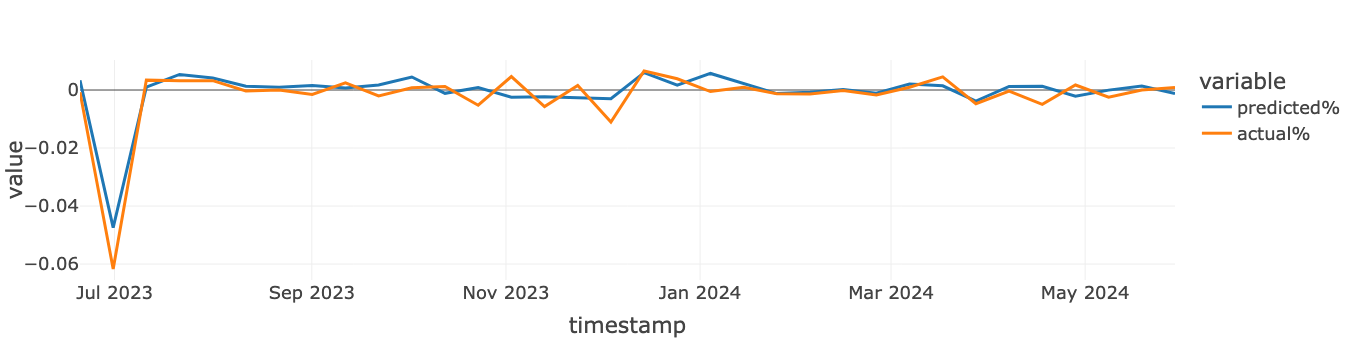

In [17]:
# cretion of CV sets
crypto = 'ADA'
model = 'SVR'
df=features.crypto_modelling[crypto][[ENDOG]+SELECTED_FEATURES_PCA]
    
#creation of test results
cv_results = CVresults(df = df,model=model,crypto=crypto, splits=splits[crypto])
cv_results.run(**{'kernel':'linear','gamma':0.2,'C':5,'epsilon':0.05})
px.line(pd.DataFrame(cv_results.test_results, columns = ['timestamp','predicted%','actual%']).set_index('timestamp'),template='presentation')

### Model testing - all cryptos

In [18]:
rerun_cv = False
#reruning CV tests for all models for all cryptos

# models ={#'linear':None,
#          'SVR(1)':{'kernel':'linear','gamma':0.2,'C':10,'epsilon':0.01},
#           'SVR(2)':{'kernel':'rbf','gamma':0.2,'C':10,'epsilon':0.05},
#           'SVR(3)':{'kernel':'poly','gamma':0.2,'C':10,'epsilon':0.01}, #['poly',0.2,10,0.01],
#           'random-forest(1)':{'n_estimators':100,'random_state':0},
#           'random-forest(2)':{'n_estimators':50,'random_state':2},
#           # 'random-forest(3)':{'n_estimators':240,'random_state':3} #n_estimators=100,random_state=0
#         }

models ={'SVR(1)':{'kernel':'linear','gamma':0.2,'C':10,'epsilon':0.05},
          'SVR(2)':{'kernel':'rbf','gamma':0.2,'C':5,'epsilon':0.01},
          'SVR(3)':{'kernel':'poly','gamma':0.2,'C':2,'epsilon':0.05}, #['poly',0.2,10,0.01],
          'random-forest(1)':{'n_estimators':30,'random_state':0},
          'random-forest(2)':{'n_estimators':50,'random_state':3},
        }


results = {}

if rerun_cv is True:
    for crypto in CRYPTOS:
        print('Running for: ',crypto)
        results[crypto] = {}
        for model, specs in models.items():
            print(model)
            
            #select crypto data modelling and filter based on the last selected features from PCA
            df=features.crypto_modelling[crypto][[ENDOG]+SELECTED_FEATURES_PCA]
        
            # creation of test results for each test/train sample
            cv_results = CVresults(df=df,model=model.split('(')[0],crypto=crypto, splits=splits[crypto])
    
            if specs is None:
                try:
                    cv_results.run()
                except:
                    print(f'Issue with {crypto}: {model}')
            else:
                try:
                    cv_results.run(**specs)
                except:
                    print(f'Issue with {crypto}: {model}')
            
            results[crypto][model] = cv_results.test_results
    
    with open('output/cv_results_new.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('output/cv_results_new.pickle', 'rb') as handle:
        results = pickle.load(handle)


### Model selection per crypto

In [19]:
def get_top_model(cryptos):
    selected_models = {}
    summary_matrix = None
    fig = {}
    # stats = {}

    for crypto in cryptos:
        df_resampled = crypto_resampled[freq][crypto].copy() #predefined
        cv_results = results[crypto].copy() #predefined
        process_results = ProcessResultsCrypto(crypto=crypto,df_resampled = df_resampled ,cv_results=cv_results) #calculated on PCA features
        process_results.run()
        
        fig[crypto] = process_results.fig
        # stats[crypto] = process_results.stats_dict
        # process_results.converted_dict['SVR(1)']
        
        summary_df = pd.DataFrame.from_dict(process_results.stats_dict, orient='index').reset_index().rename(columns={'index':'model'})
        summary_df = summary_df[summary_df['model']!='linear']
        summary_df['crypto'] = crypto
        summary_df = summary_df[['crypto','model','D%','MAPE']]
        selected_model = summary_df.sort_values(by=['D%', 'MAPE'], ascending=[False, True])['model'].values[0]

        selected_models[crypto] = selected_model

        summary_matrix = summary_df if summary_matrix is None else pd.concat([summary_matrix,summary_df],ignore_index=True)
        summary_matrix.to_excel(f'output/top_models_{datetime.now().date()}.xlsx')


    return selected_models, summary_matrix, fig
    
selected_models, summary_matrix, fig = get_top_model(results)

top_models = pd.DataFrame.from_dict(selected_models, orient='index',columns = ['model'])
top_models.reset_index().groupby('model').count().sort_values('index').rename(columns = {'index':'#cryptos'}).sort_values('#cryptos',ascending = False)

,#cryptos
model,
random-forest(1),22
random-forest(2),20
SVR(2),14


In [27]:
# top_models.reset_index().sort_values('index').set_index('index')

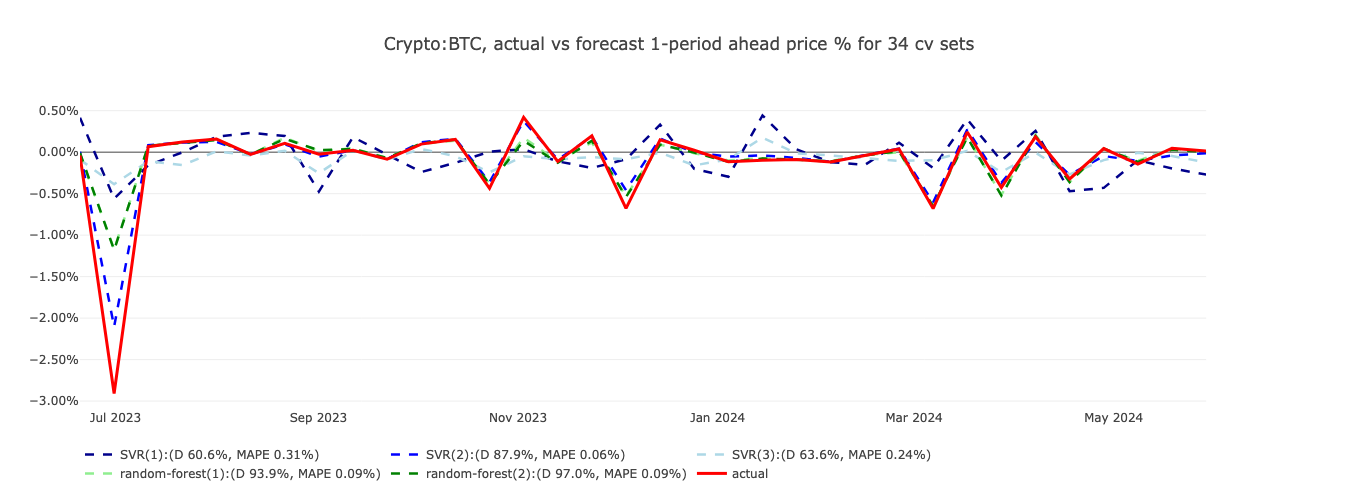

In [21]:
fig['BTC']#.keys()#['NULL']

### Model training on historical

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def train_model(df, endog,**args):

    EXOG = [i for i in df.columns if i != endog]

    x_train = np.array(df[EXOG])
    y_train = np.array(df[endog].values)
    assert len(x_train) == len(y_train)
    
    regressor = RandomForestRegressor(**args, oob_score=True)
    regressor.fit(x_train, y_train)

    return regressor

random_forest_trained = {}
selected_params = {'n_estimators':30,'random_state':0}
for crypto in CRYPTOS:
    df=features.crypto_modelling[crypto][[ENDOG]+SELECTED_FEATURES_PCA]
    regressor = train_model(df,endog ='close%',**selected_params)
    random_forest_trained[crypto] = regressor


### Optimal portfolio selection

#### Get latest data

In [28]:
import time
from optimal_portfolio import *

download_new = False

if download_new is True:
    new_data_all = {}
    for crypto in CRYPTOS:
        try:
            df = get_latest_data(crypto)
            
            #final adj
            df = df.groupby('timestamp').mean()
        
            new_data_all[crypto] = df.copy() #add_features.crypto_added_features.copy()
            
        except Exception as e:
            print(f'Unable to retrieve data for {crypto}')
    
    with open('output/new_data_all.pickle', 'wb') as handle:
            pickle.dump(new_data_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('output/new_data_all.pickle', 'rb') as handle:
        new_data_all = pickle.load(handle)

    
#combine for a common timeframe for trading test
combined_close = None
for crypto, df in new_data_all.items():
    _df = df[['close']].rename(columns = {'close':crypto})
    combined_close = _df if combined_close is None else combined_close.merge(_df,how='outer',left_index=True,right_index=True)
combined_close = combined_close.drop(columns=['OMG','TOMO','WAVES','PERL','XMR','TFUEL']).T.dropna(how = 'all',axis=1).T
final_cryptos = list(combined_close.columns)
final_index = list(combined_close.index)


In [29]:
# adjust the new data, add features, use trained model to predict price & calculate average to be used 
modelling_new = {}
average_price = {}
predicted_return = {} 

for crypto in final_cryptos:
    df = new_data_all[crypto].reindex(final_index)
    add_features = FeatureCrypto(raw_df=df)
    add_features.run()
    new_data = add_features.crypto_added_features.dropna(axis=0)

    price = new_data[['open','high','low']].mean(axis=1)
    average_price[crypto] = price
    
    x_test = np.array(new_data[SELECTED_FEATURES_PCA])
    predicted = random_forest_trained[crypto].predict(x_test)
    predicted_return[crypto]=predicted
    
    modelling_new[crypto]=new_data #period, x_test,
    
    assert len(new_data) == len(predicted) == len(price)

iteration_timeframe = list(new_data.index)

NameError: name 'random_forest_trained' is not defined

In [ ]:
#get covariance matrix from historical last overlapping data
df_all = None
for crypto, df in crypto_resampled[freq].items():
    _df =  crypto_resampled[freq][crypto][['close%']].rename(columns = {'close%':crypto})
    df_all = _df if df_all is None else df_all.merge(_df,left_index=True,right_index=True,how='outer')
    
df_all = df_all[final_cryptos].dropna()[-1000:]
cov_matrix = df_all.cov()

#place predicted returns in ok format for script
predicted_returns_all = None 
for crypto  in final_cryptos:
    assert len(predicted_return[crypto]) == len(iteration_timeframe), crypto
    _df = pd.DataFrame(predicted_return[crypto],iteration_timeframe,columns=[crypto])
    predicted_returns_all = _df if predicted_returns_all is None else predicted_returns_all.merge(_df,how='outer',left_index=True,right_index=True)

assert np.sum(predicted_returns_all.columns != cov_matrix.columns) == 0


In [ ]:
# def adder_factory(n):
    
#     def add_fn(x):
#         return x + n

#     return add_fn

# f1 = adder_factory(n=1)

# f2 = adder_factory('sdasd')
# f2('afsasf')

In [ ]:
initial_investment = 10_000
cash = initial_investment
crypto_holdings = {crypto: 0 for crypto in final_cryptos}
portfolio_value = [initial_investment]
transaction_fee = 0.0025

results = pd.DataFrame(columns=['Date', 'Portfolio_Value'])
previous_optimal_weights = np.array([1/len(final_cryptos)] * len(final_cryptos))

# DataFrames to store buy and sell volumes
buy_volumes_df = pd.DataFrame(columns=final_cryptos)
sell_volumes_df = pd.DataFrame(columns=final_cryptos)

#change iteration time frame to 1 hour
# iteration_timeframe = [i for i in iteration_timeframe if ':45:00' in str(i) ]

for timestamp in iteration_timeframe:
    # Mean returns and covariance matrix for the predicted period
    mean_returns = predicted_returns_all.loc[timestamp]
    
    # Calculate optimal weights
    optimal_weights = get_optimal_weights(mean_returns, cov_matrix)    
    
    buy_volumes = {}
    sell_volumes = {}
    for j, crypto in enumerate(final_cryptos):
        weight_change = optimal_weights[j] - previous_optimal_weights[j]
        
        if weight_change > 0:
            # Buy transaction
            amount_to_invest = cash * weight_change
            if np.isnan(amount_to_invest):
                print(f"NaN value encountered in amount_to_invest for {crypto}. Skipping this transaction.")
                continue
            cash -= amount_to_invest * (1 + transaction_fee)
            price = average_price[crypto][timestamp] #get_latest_price(crypto)
            buy_volume = amount_to_invest / price
            crypto_holdings[crypto] += buy_volume
            buy_volumes[crypto] = buy_volume
        elif weight_change < 0:
            # Sell transaction
            amount_to_sell = crypto_holdings[crypto] * -weight_change
            if np.isnan(amount_to_sell):
                print(f"NaN value encountered in amount_to_sell for {crypto}. Skipping this transaction.")
                continue
            price = average_price[crypto][timestamp] #get_latest_price(crypto)
            cash += amount_to_sell * price * (1 - transaction_fee)
            sell_volume = amount_to_sell
            crypto_holdings[crypto] -= sell_volume
            sell_volumes[crypto] = sell_volume
    
    # Print buy and sell volumes for the current period
    if buy_volumes:
        print(f"Buy Volumes - {buy_volumes}")
        buy_volumes_df = pd.concat([buy_volumes_df, pd.DataFrame(buy_volumes,index=[1])],ignore_index=True)
        
    if sell_volumes:
        print(f"Sell Volumes - {sell_volumes}")
        sell_volumes_df = pd.concat([sell_volumes_df, pd.DataFrame(sell_volumes,index=[1])],ignore_index=True)
    
    # # Update the previous optimal weights
    previous_optimal_weights = optimal_weights
    
    # # Calculate current portfolio value
    portfolio_val = cash + sum(crypto_holdings[crypto] * get_latest_price(crypto) for crypto in final_cryptos)
    portfolio_value.append(portfolio_val)
    
    # # Store results
    new_row = pd.DataFrame({'Date': [timestamp], 'Portfolio_Value': [portfolio_val]})
    results = pd.concat([results, new_row], ignore_index=True)



In [38]:
with open('output/portfolio_values.pickle', 'rb') as handle:
    portfolio_values = pickle.load(handle)

key = 'latest_data_one_hour' #latest_data
results = portfolio_values[key][1]#results  latest_data
iteration_timeframe  = portfolio_values[key][0] #timestamp

In [39]:
@interact
def compare(relative_to = ['BTC','ADA','ETH'],change = True):
    
    one_crypto =new_data_all[relative_to].reindex(iteration_timeframe)[['close']]
    one_crypto = one_crypto.pct_change() if change is True else one_crypto
    std_coin = np.round(np.std(one_crypto)[0]*100,3)
    mean_return = np.round(np.mean(one_crypto)*100,3)
    
    portoflio = pd.DataFrame(results['Portfolio_Value'].values,iteration_timeframe,columns =['Portfolio value'])
    portoflio = portoflio.pct_change() if change is True else portoflio
    std_portoflio = np.round(np.std(portoflio)[0]*100,3)
    mean_return_p = np.round(np.mean(portoflio)*100,3)
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(y =portoflio['Portfolio value']
                                ,x = portoflio.index
                                , name = 'portfolio'
                                ,marker_color = 'red'
                            ),secondary_y = False)
    
    fig.add_trace(go.Scatter(y =one_crypto['close']
                                ,x = one_crypto.index
                                , name = relative_to
                                ,marker_color = 'blue'
                            ),secondary_y = False if change is True else True)
    
    title = f'Portfolio overview ({"change" if change is True else "level"}) vs {relative_to}' 
    title += f'<br>Portoflio: mean return {mean_return_p},std {std_portoflio}, Coin: mean return {mean_return} ,std {std_coin}' if change is True else ''
    yaxis = {'title':'portfolio','tickformat':".2%",'showgrid':False} if change is True else {'title':'','showgrid':False}
    
    fig.update_layout(template='presentation'
                      ,title=title
                      ,height=500
                      ,width=1500
                      ,yaxis=yaxis
                      ,xaxis={'title':''}
                      ,font_size=12
                      ,legend=dict(
                        orientation="h",
                    )
                      ,showlegend=True).update_yaxes(tickformat= "" ,secondary_y = True)
    
    return  fig.show()


interactive(children=(Dropdown(description='relative_to', options=('BTC', 'ADA', 'ETH'), value='BTC'), Checkbo…

In [ ]:
# portfolio_values['latest_data_one_hour'] = [iteration_timeframe,results,sell_volumes_df,buy_volumes_df]

In [ ]:
# portfolio_values = {'latest_data':[iteration_timeframe,results,sell_volumes_df,buy_volumes_df]} #timeframe, results
# with open('output/portfolio_values.pickle', 'wb') as handle:
#     pickle.dump(portfolio_values, handle, protocol=pickle.HIGHEST_PROTOCOL)